In [1]:

import time
import numpy as np
import cv2
import scipy.special
import matplotlib.pyplot as plt
import os
import csv

from os import listdir
from os.path import isfile, join
import pandas
from scipy import ndimage
import random

In [2]:
def to_crop_img(image):
  #image = cv2.imread(img_name)

  
  img = image.copy()
  image = cv2.resize(img,(len(img[0])//5,len(img)//5))

  img = cv2.blur(img,(15,15))

  img = cv2.resize(img,(len(img[0])//5,len(img)//5))

  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Find Canny edges
  #edged = cv2.Canny(img, 25, 250)
  edged = cv2.threshold(img, 125, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]


  contours, hierarchy = cv2.findContours(edged, 
      cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

  max_position = 0
  max_value = 0
  for i in range(len(contours)):
      #print(contours[i].shape)
      if(contours[i].shape[0]>max_value):
          max_value = contours[i].shape[0]
          max_position = i
          

  x,y,w,h = cv2.boundingRect(contours[max_position])
  #print(w,' ',h,' ',w/h)
  crop_img = image[y:y+h, x:x+w]
  if(w/h > 0.59):
      rotate = ndimage.rotate(crop_img, 0-((w/h-0.54)*100),cval=205.0)
      img_rotate = cv2.blur(rotate,(1,1))
      img_rotate = cv2.cvtColor(img_rotate, cv2.COLOR_BGR2GRAY)
      rotate_edged = cv2.threshold(img_rotate, 125, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
      #cv2.imshow('img_rotate',rotate_edged)
      contours_rotate, hierarchy_rotate = cv2.findContours(rotate_edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
      max_position_rotate = 0
      max_value_rotate = 0
      for i in range(len(contours_rotate)):
          #print(contours[i].shape)
          if(contours_rotate[i].shape[0]>max_value_rotate):
              max_value_rotate = contours_rotate[i].shape[0]
              max_position_rotate = i
      x_rotate,y_rotate,w_rotate,h_rotate = cv2.boundingRect(contours_rotate[max_position_rotate])
      crop_img_rotate = rotate[y_rotate:y_rotate+h_rotate, x_rotate:x_rotate+w_rotate]
      #print(w_rotate/h_rotate)
      ratio_unclockwise = w_rotate/h_rotate
      if(w_rotate/h_rotate >0.59):
          rotate = ndimage.rotate(crop_img, ((w/h-0.57)*100),cval=205.0)
          img_rotate = cv2.blur(rotate,(1,1))
          img_rotate = cv2.cvtColor(img_rotate, cv2.COLOR_BGR2GRAY)
          rotate_edged = cv2.threshold(img_rotate, 125, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
          #cv2.imshow('img_rotate',rotate_edged)
          contours_rotate, hierarchy_rotate = cv2.findContours(rotate_edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
          max_position_rotate = 0
          max_value_rotate = 0
          for i in range(len(contours_rotate)):
              #print(contours[i].shape)
              if(contours_rotate[i].shape[0]>max_value_rotate):
                  max_value_rotate = contours_rotate[i].shape[0]
                  max_position_rotate = i
          x_rotate,y_rotate,w_rotate,h_rotate = cv2.boundingRect(contours_rotate[max_position_rotate])
          crop_img_rotate = rotate[y_rotate:y_rotate+h_rotate, x_rotate:x_rotate+w_rotate]
          #print(w_rotate/h_rotate)
          ratio_clockwise = w_rotate/h_rotate
          if (ratio_clockwise>ratio_unclockwise):
            rotate = ndimage.rotate(crop_img, 0-((w/h-0.54)*100),cval=205.0)
            img_rotate = cv2.blur(rotate,(1,1))
            img_rotate = cv2.cvtColor(img_rotate, cv2.COLOR_BGR2GRAY)
            rotate_edged = cv2.threshold(img_rotate, 125, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
            #cv2.imshow('img_rotate',rotate_edged)
            contours_rotate, hierarchy_rotate = cv2.findContours(rotate_edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            max_position_rotate = 0
            max_value_rotate = 0
            for i in range(len(contours_rotate)):
                #print(contours[i].shape)
                if(contours_rotate[i].shape[0]>max_value_rotate):
                    max_value_rotate = contours_rotate[i].shape[0]
                    max_position_rotate = i
            x_rotate,y_rotate,w_rotate,h_rotate = cv2.boundingRect(contours_rotate[max_position_rotate])
            crop_img_rotate = rotate[y_rotate:y_rotate+h_rotate, x_rotate:x_rotate+w_rotate]
            #print(w_rotate/h_rotate)
      #cv2.imshow('rotate',crop_img_rotate)
      crop_img = crop_img_rotate #
  
  return crop_img

In [3]:
def avg_in_scale(crop_img):
  crop_img = img = cv2.resize(crop_img,(275,512))
  avg_scale_from_crop = []
  count = 0
  for row_line in range(len(crop_img)//30-2):
    for col_line in range(len(crop_img[0])//30-2):
      img_scale = crop_img[(row_line+1)*30:(row_line+1)*30+30, (col_line+1)*30:(col_line+1)*30+30]
      avg_pix = 0
      for row in range(len(img_scale)):
        for col in range(len(img_scale[0])):
          avg_pix += sum(img_scale[row][col])/3
      avg_scale_from_crop.append(avg_pix)
      count+=1


  return np.array(avg_scale_from_crop)


In [4]:
# neural network class definition
class neuralNetwork :

    # initialise the neural network
    def __init__(self, inputnodes, hiddennodes, outputnodes,learningrate,send_weight_state = False,weight = 0) :


        # set number of nodes in each input, hidden, output layer
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes
        self.weight_each_epochs = []
        self.bias_each_epochs = []

        self.set_w  = []
        if (send_weight_state):
            self.set_w = weight
        #set weight
        else:
          #self.w = np.random.normal(0.0, pow(self.onodes, -0.5),(self.onodes, self.inodes))
          self.set_w.append(np.random.normal(0.0, pow(self.inodes, -0.5),(self.hnodes[0], self.inodes)))
          for i in range(1,len(self.hnodes)):
              self.set_w.append(np.random.normal(0.0, pow(self.hnodes[i-1], -0.5),(self.hnodes[i], self.hnodes[i-1])))
          self.set_w.append(np.random.normal(0.0, pow(self.hnodes[-1], -0.5),(self.onodes, self.hnodes[-1])))
          self.set_w = np.array(self.set_w)

        # learning rate
        self.lr = learningrate
        self.bias = []
        for i in range(len(self.hnodes)+1):
            self.bias.append(1)
        self.bias = np.array(self.bias)
        

        # activation function is the sigmoid function
        self.activation_function = lambda x: scipy.special.expit(x)
        #self.derivative_function = lambda x: 1 if x>0 else 0 if x==0 else -1

        pass
   
    

    # train the neural network
    def train(self, inputs_list, targets_list) :
        # convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        # print('targets = ', targets)

        result_each_layer_set = []
        # w_dot_input = np.dot(self.w, inputs)
        # outputs = self.activation_function(w_dot_input+1)
        result_each_layer_set.append(self.activation_function(np.dot(self.set_w[0], inputs)+self.bias[0]))
        for i in range(len(self.hnodes)):
            result_each_layer_set.append(self.activation_function(np.dot(self.set_w[i+1], result_each_layer_set[i])+self.bias[i+1]))
        

        # output layer error is the (target actual)
        #output_errors = targets-outputs
        error_set = []
        output_errors = targets-result_each_layer_set[-1]
        
        error_set.append(output_errors)
        for i in range(len(self.hnodes)):
            error_set.append(np.dot(self.set_w[0-(i+1)].T,error_set[i]))
        
        # print(error_set)
        # print(self.set_w)
        



        
        
        # update the weights 
       
        # self.w += self.lr * np.dot((output_errors*outputs * (1.0-outputs)),np.transpose(inputs)) 
        for i in range(len(error_set)-1):
            self.set_w[0-(i+1)] += self.lr * np.dot((error_set[i] * result_each_layer_set[0-(i+1)] * (1.0 - result_each_layer_set[0-(i+1)])), np.transpose(result_each_layer_set[0-(i+2)]))
            self.bias[0-(i+1)] +=  self.lr*self.bias[0-(i+1)] *sum(error_set[i] * result_each_layer_set[0-(i+1)] * (1.0 - result_each_layer_set[0-(i+1)]))
        self.set_w[0] += self.lr * np.dot((error_set[-1] * result_each_layer_set[0] * (1.0 - result_each_layer_set[0])), np.transpose(inputs))
        self.bias[0] +=  self.lr *self.bias[0] *sum(error_set[-1] * result_each_layer_set[0] * (1.0 - result_each_layer_set[0]))

        self.weight_each_epochs.append(self.set_w.copy())
        self.bias_each_epochs.append(self.bias)
        # print(self.set_w[1][2])
        # print("********************")
        


        # print("*********")
        pass

    # query the neural network
    def query(self, inputs_list) :

        # convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T


        # output = np.dot(self.w, inputs)

        # # calculate the signals emerging 
        # final_outputs = self.activation_function(output)

        result_each_layer_set = []
        result_each_layer_set.append(self.activation_function(np.dot(self.set_w[0], inputs)+self.bias[0]))
        for i in range(len(self.hnodes)):
            result_each_layer_set.append(self.activation_function(np.dot(self.set_w[i+1], result_each_layer_set[i])+self.bias[i+1]))
        
        final_outputs = result_each_layer_set[-1]

        return final_outputs
    
   
    # def write_weight(self) :
    #     f = open('who.txt','w',encoding='utf-8')
    #     f.write(str(self.who))
    #     f.close()
    #     f = open('wih.txt','w',encoding='utf-8')
    #     f.write(str(self.wih))
    #     f.close()
    #     print('already write!! ')
        

In [5]:
from google.colab import drive
drive.mount('/content/drive')

!unzip drive/"My Drive"/korat_sauce/train_data_use_color2.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  drive/My Drive/korat_sauce/train_data_use_color2.zip
   creating: train_data/
  inflating: train_data/maeyupa.0.jpg  
  inflating: train_data/maeyupa.1.jpg  
  inflating: train_data/maeyupa.100.jpg  
  inflating: train_data/maeyupa.101.jpg  
  inflating: train_data/maeyupa.108.jpg  
  inflating: train_data/maeyupa.109.jpg  
  inflating: train_data/maeyupa.110.jpg  
  inflating: train_data/maeyupa.111.jpg  
  inflating: train_data/maeyupa.112.jpg  
  inflating: train_data/maeyupa.113.jpg  
  inflating: train_data/maeyupa.12.jpg  
  inflating: train_data/maeyupa.120.jpg  
  inflating: train_data/maeyupa.121.jpg  
  inflating: train_data/maeyupa.122.jpg  
  inflating: train_data/maeyupa.123.jpg  
  inflating: train_data/maeyupa.124.jpg  
  inflating: train_data/maeyupa.125.jpg  
  inflating: train_data/maeyupa.13.jpg  
  inflating: train_data/maeyupa.1

In [6]:
mypath = 'train_data/'
imagePaths = [mypath+f for f in listdir(mypath) if isfile(join(mypath, f))]

In [7]:
train_list = []
train_list_ans = []

# check_type = []

for (i, img_path) in enumerate(imagePaths):
      # if not (img_path.split(".")[0].split("/")[1] in check_type):
      #     check_type.append(img_path.split(".")[0].split("/")[1])
          # print(check_type)
        img = cv2.imread(img_path)
        crop_img = to_crop_img(img) 
        
        avg_img = avg_in_scale(crop_img)
        min_avg = min(avg_img)
        max_avg = max(avg_img)
        for i in range(len(avg_img)):
            avg_img[i] = (avg_img[i]-min_avg)/(max_avg-min_avg)
        train_list.append(avg_img)
        product_name = img_path.split(".")[0].split("/")[1]
        product_class = 0
        if (product_name == "maeyupa"):
            product_class = 1
        elif (product_name == "ocean"):
            product_class = 2
        elif (product_name == "zapnuer"):
            product_class = 3
        elif (product_name == "zapnuerchick"):
            product_class = 4
        
        targets = np.zeros(4) + 0.01
        
        
        targets[product_class-1] = 0.99
        train_list_ans.append(targets)
          # if(len(check_type)==4):
          #     break

              
      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


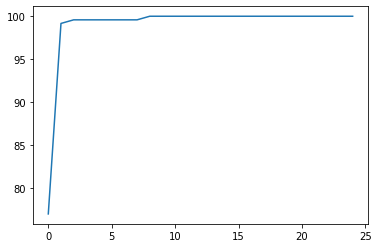

100.0
8


In [8]:

accuracy_each_epochs = []


input_nodes = 105
output_nodes = 4
# hidden_nodes = 21
hidden_nodes = [11]

learning_rate = 0.1
#hidden_layers = 1

weight_each_epochs = []
bias_each_epochs = []


###

n = neuralNetwork(input_nodes,hidden_nodes,output_nodes,learning_rate)


weight_each_epochs.append([])
for i in range(len(hidden_nodes)+1):
  weight_each_epochs[-1].append(n.set_w[i].copy())
bias_each_epochs.append(n.bias.copy())



epochs = 25
for e in range(epochs):
    
    for i in range(len(train_list)):
        inputs =  train_list[i]        
        targets = train_list_ans[i]
        n.train(inputs, targets)
        pass
    pass
    weight_each_epochs.append([])
    for i in range(len(hidden_nodes)+1):
      weight_each_epochs[-1].append(n.set_w[i].copy())
    bias_each_epochs.append(n.bias.copy())


    #test
    
    scorecard = []

    # go through all the records in the test data set
    for  i in range(len(train_list)):
        inputs =  train_list[i]
        ans = np.argmax(train_list_ans[i])
      
               
        outputs = n.query(inputs)
        
        # the index of the highest value corresponds to the label
        label = np.argmax(outputs)

        
        # append correct or incorrect to list
        if (label == ans):
            
            scorecard.append(1)
        else:
            # network's answer doesn't match correct answer, add 0 to scorecard
            scorecard.append(0)
            pass
        pass
    # calculate the performance score, the fraction of correct answers
    scorecard_array = np.asarray(scorecard)
    #print ("performance = ", scorecard_array.sum() /scorecard_array.size*100)
    accuracy_each_epochs.append(scorecard_array.sum() /scorecard_array.size*100)
    # if(scorecard_array.sum() /scorecard_array.size*100 >= 100):
    #   break

plt.plot(np.arange(len(accuracy_each_epochs)),np.array(accuracy_each_epochs)) 
plt.show()
print(max(accuracy_each_epochs))
print(np.argmax(accuracy_each_epochs))

In [9]:
n.set_w

array([array([[ 0.25579171,  0.4000327 ,  0.10604958, ...,  0.05774465,
         0.16672718, -0.0432731 ],
       [ 1.45553607,  0.54258745,  0.3777906 , ...,  0.8579256 ,
         0.4411817 ,  0.14801106],
       [-0.56175839, -0.2594801 , -0.21909621, ..., -0.283917  ,
        -0.06981743, -0.20020763],
       ...,
       [ 1.15358985,  0.74998475,  0.36183034, ...,  0.61741254,
         0.14537976, -0.54361345],
       [ 0.27327189,  0.18283325,  0.2424945 , ...,  0.06956404,
         0.09178299,  0.04785142],
       [-0.27723438, -0.32537412, -0.40014909, ..., -1.30436516,
        -1.36207399, -1.35778258]]),
       array([[-0.82466514, -1.26395243, -0.12959714, -3.19375018,  1.97793246,
        -0.54669487,  0.66327756,  0.97584989, -1.0587495 , -0.65252512,
         1.56127046],
       [-0.56786861, -1.41759374, -0.18806046,  1.79091346, -2.30544114,
        -0.30112895,  1.04990232,  1.70639256, -1.71387771, -0.44945173,
        -2.67325844],
       [-0.4778333 ,  2.80219114, -1

In [10]:
weight_each_epochs[0][0][0]

array([-0.03578262,  0.18683306, -0.07608693,  0.04184622,  0.03997878,
        0.09970142,  0.16125682, -0.10081522, -0.04578524,  0.02752087,
       -0.10746797,  0.05516559,  0.06518746, -0.09422027,  0.01206952,
       -0.12997632,  0.03809053, -0.01544701,  0.08796332,  0.10777949,
       -0.09137931,  0.0571796 ,  0.1064619 ,  0.00175972, -0.21196788,
        0.12138696, -0.03240626, -0.09014871,  0.11762651,  0.0160538 ,
        0.12190868, -0.14576274,  0.06628175, -0.0874043 ,  0.05586361,
        0.04092533,  0.01495397,  0.05021953, -0.07955559,  0.04470933,
       -0.17432588,  0.06153638, -0.01575012,  0.1415769 ,  0.05873577,
       -0.17260815, -0.07795587,  0.14427407, -0.02865138,  0.08495645,
        0.05724451,  0.04077248, -0.04931802,  0.01040586,  0.07658295,
        0.05251198, -0.07634245, -0.06020828, -0.1156483 , -0.01015481,
        0.15676087, -0.0678543 ,  0.06060203,  0.11886381, -0.04032635,
       -0.14305368, -0.01023239,  0.0909858 , -0.08965769,  0.01

In [11]:
weight_each_epochs[20][0][0]

array([ 0.25175722,  0.39700749,  0.10342036,  0.23225846,  0.21188166,
        0.32291662,  0.38812075,  0.1453765 ,  0.12019922,  0.15974895,
        0.02683351,  0.21905396,  0.27022002,  0.09435281,  0.20357343,
       -0.01585196,  0.13157508,  0.08462027,  0.21662503,  0.26641973,
        0.03944435,  0.22950037,  0.21337317,  0.08749912, -0.09811347,
        0.25073777,  0.08181082,  0.00260295,  0.31440542,  0.17323456,
        0.25145918,  0.00836148,  0.22735953,  0.05510464,  0.15403541,
        0.2522397 ,  0.17544585,  0.18237229,  0.06010447,  0.1931429 ,
       -0.05468234,  0.12511625,  0.16636211,  0.27896409,  0.15762571,
       -0.05133967,  0.05296938,  0.22748499,  0.0230406 ,  0.28563891,
        0.15997876,  0.13473687,  0.05127144,  0.08111494,  0.13684935,
        0.12019741,  0.10327699,  0.04597228, -0.03449218,  0.05449125,
        0.22620423,  0.00816974,  0.16687585,  0.29116365,  0.11189748,
       -0.00119511,  0.0761092 ,  0.21020889,  0.04685278,  0.14

In [15]:
len(weight_each_epochs[25][0][0])

105

In [20]:
len(n.set_w[0])

11

In [45]:
str_weight = "np.array(["
for i in range(len(n.set_w)):
  str_weight+="["
  for j in range(len(n.set_w[i])):
    str_weight+="["
    for k in range(len(n.set_w[i][j])):
      str_weight+=str(n.set_w[i][j][k])+","
    if (k == len(n.set_w[i][j])-1):
      str_weight = str_weight[:-1]
    str_weight+="],"
   
  
  str_weight+="],"
  

str_weight+="])"

In [46]:
a = '12345678'
a[:-1]

'1234567'

In [47]:
f = open("weight_test.txt", "w")
f.write(str_weight)
f.close()

In [52]:
str_weight = "np.array(["
for i in range(len(weight_each_epochs[25])):
  str_weight+="["
  for j in range(len(weight_each_epochs[25][i])):
    str_weight+="["
    for k in range(len(weight_each_epochs[25][i][j])):
      str_weight+=str(weight_each_epochs[25][i][j][k])+","
    if (k == len(weight_each_epochs[25][i][j])-1):
      str_weight = str_weight[:-1]
    str_weight+="],"
   
  
  str_weight+="],"
  

str_weight+="])"

In [53]:
f = open("weight_for_use.txt", "w")
f.write(str_weight)
f.close()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip drive/"My Drive"/korat_sauce/test_data_use_color2.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  drive/My Drive/korat_sauce/test_data_use_color2.zip
   creating: test_data/
  inflating: test_data/maeyupa.10.jpg  
  inflating: test_data/maeyupa.102.jpg  
  inflating: test_data/maeyupa.103.jpg  
  inflating: test_data/maeyupa.104.jpg  
  inflating: test_data/maeyupa.105.jpg  
  inflating: test_data/maeyupa.106.jpg  
  inflating: test_data/maeyupa.107.jpg  
  inflating: test_data/maeyupa.11.jpg  
  inflating: test_data/maeyupa.114.jpg  
  inflating: test_data/maeyupa.115.jpg  
  inflating: test_data/maeyupa.116.jpg  
  inflating: test_data/maeyupa.117.jpg  
  inflating: test_data/maeyupa.118.jpg  
  inflating: test_data/maeyupa.119.jpg  
  inflating: test_data/maeyupa.126.jpg  
  inflating: test_data/maeyupa.127.jpg  
  inflating: test_data/maeyupa.128.jpg  
  inflating: test_data/maeyupa.129.jpg  
  inflating: test_data/maeyupa.130.jpg  
  inflat

In [ ]:
testpath = 'test_data/'
imageTestPaths = [testpath+f for f in listdir(testpath) if isfile(join(testpath, f))]

In [ ]:
test_list = []
test_list_ans = []
for (i, img_path_test) in enumerate(imageTestPaths):
      img = cv2.imread(img_path_test)
      crop_img = to_crop_img(img)
      # orange_val = detect_orange(img)
      # yellow_val = detect_yellow(img)
      # green_val = detect_green(img)
      # color_list = np.array([orange_val,yellow_val,green_val])
      #test_list.append(np.array([(x-min(color_list))/(max(color_list)-min(color_list))  for x in color_list])+0.01)
      avg_img = avg_in_scale(crop_img)
      min_avg = min(avg_img)
      max_avg = max(avg_img)
      for i in range(len(avg_img)):
          avg_img[i] = (avg_img[i]-min_avg)/(max_avg-min_avg) 
      test_list.append(avg_img)
      product_name = img_path_test.split(".")[0].split("/")[1]
      product_class = 0
      if (product_name == "maeyupa"):
          product_class = 1
      elif (product_name == "ocean"):
          product_class = 2
      elif (product_name == "zapnuer"):
          product_class = 3
      elif (product_name == "zapnuerchick"):
          product_class = 4

      test_list_ans.append(product_class-1)

In [ ]:
fail_num = 1
scorecard = []
for  i in range(len(test_list)):
    inputs =  test_list[i]
    ans = test_list_ans[i]
  
            
    outputs = n.query(inputs)
    
    # the index of the highest value corresponds to the label
    label = np.argmax(outputs)
    
    # append correct or incorrect to list
    if (label == ans):
        
        scorecard.append(1)
    else:
        # network's answer doesn't match correct answer, add 0 to scorecard
        scorecard.append(0)
        
        print(fail_num,' ',ans,' ',np.transpose(outputs))
        fail_num+=1
        pass
    pass
# calculate the performance score, the fraction of correct answers
scorecard_array = np.asarray(scorecard)
print ("performance = ", scorecard_array.sum() /scorecard_array.size*100)

performance =  100.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip drive/"My Drive"/korat_sauce/test_after_train8_1.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  drive/My Drive/korat_sauce/test_after_train8_1.zip
   creating: test_after_train8/
  inflating: test_after_train8/maeyupa.0.jpg  
  inflating: test_after_train8/maeyupa.1.jpg  
  inflating: test_after_train8/maeyupa.10.jpg  
  inflating: test_after_train8/maeyupa.100.jpg  
  inflating: test_after_train8/maeyupa.101.jpg  
  inflating: test_after_train8/maeyupa.102.jpg  
  inflating: test_after_train8/maeyupa.103.jpg  
  inflating: test_after_train8/maeyupa.104.jpg  
  inflating: test_after_train8/maeyupa.105.jpg  
  inflating: test_after_train8/maeyupa.106.jpg  
  inflating: test_after_train8/maeyupa.107.jpg  
  inflating: test_after_train8/maeyupa.11.jpg  
  inflating: test_after_train8/maeyupa.111.jpg  
  inflating: test_after_train8/maeyupa.112.jpg  
  inflating: test_after_train8/maeyupa.113.jpg  
  inflating: test_after_train8/maeyupa.114.jpg  


In [ ]:
testAfterTrainpath8 = 'test_after_train8/'
imageTestAfterTrainPaths8  = [testAfterTrainpath8 +f for f in listdir(testAfterTrainpath8 ) if isfile(join(testAfterTrainpath8 , f))]

In [ ]:
test_after_train_list8 = []
test_after_train_list_ans8 = []
for (i, img_path_test_after_train8) in enumerate(imageTestAfterTrainPaths8):
      img = cv2.imread(img_path_test_after_train8)
      crop_img = to_crop_img(img)
      # orange_val = detect_orange(img)
      # yellow_val = detect_yellow(img)
      # green_val = detect_green(img)
      # color_list = np.array([orange_val,yellow_val,green_val])
      #test_list.append(np.array([(x-min(color_list))/(max(color_list)-min(color_list))  for x in color_list])+0.01) 
      avg_img = avg_in_scale(crop_img)
      min_avg = min(avg_img)
      max_avg = max(avg_img)
      for i in range(len(avg_img)):
          avg_img[i] = (avg_img[i]-min_avg)/(max_avg-min_avg) 
      test_after_train_list8.append(avg_img)
      product_name = img_path_test_after_train8.split(".")[0].split("/")[1]
      product_class = 0
      if (product_name == "maeyupa"):
          product_class = 1
      elif (product_name == "ocean"):
          product_class = 2
      elif (product_name == "zapnuer"):
          product_class = 3
      elif (product_name == "zapnuerchick"):
          product_class = 4

      test_after_train_list_ans8.append(product_class-1)

In [ ]:
miss_list = []
fail_num = 1
scorecard = []
for  i in range(len(test_after_train_list8)):
    inputs =  test_after_train_list8[i]
    ans = test_after_train_list_ans8[i]
  
            
    outputs = n.query(inputs)
    
    # the index of the highest value corresponds to the label
    label = np.argmax(outputs)
    
    # append correct or incorrect to list
    if (label == ans):
        
        scorecard.append(1)
    else:
        # network's answer doesn't match correct answer, add 0 to scorecard
        scorecard.append(0)
        
        print(fail_num,' ',ans,' ',np.transpose(outputs),'  ',imageTestAfterTrainPaths8[i])
        miss_list.append(imageTestAfterTrainPaths8[i])
        fail_num+=1
        pass
    pass
# calculate the performance score, the fraction of correct answers
scorecard_array = np.asarray(scorecard)
print ("performance = ", scorecard_array.sum() /scorecard_array.size*100)
miss_list

performance =  100.0


[]

In [ ]:
testAfter1 = 'test1/'
imageTestAfter1  = [testAfter1 +f for f in listdir(testAfter1 ) if isfile(join(testAfter1 , f))]

In [ ]:
test_after_list1 = []
test_after_ans1 = []
for (i, img_path_test_after1) in enumerate(imageTestAfter1):
      img = cv2.imread(img_path_test_after1)
      crop_img = to_crop_img(img)
      # orange_val = detect_orange(img)
      # yellow_val = detect_yellow(img)
      # green_val = detect_green(img)
      # color_list = np.array([orange_val,yellow_val,green_val])
      #test_list.append(np.array([(x-min(color_list))/(max(color_list)-min(color_list))  for x in color_list])+0.01) 
      crop_img[0][0]
      avg_img = avg_in_scale(crop_img)
      min_avg = min(avg_img)
      max_avg = max(avg_img)
      for i in range(len(avg_img)):
          avg_img[i] = (avg_img[i]-min_avg)/(max_avg-min_avg) 
      test_after_list1.append(avg_img)
      product_name = img_path_test_after1.split(".")[0].split("/")[1]
      product_class = 0
      if (product_name == "maeyupa"):
          product_class = 1
      elif (product_name == "ocean"):
          product_class = 2
      elif (product_name == "zapnuer"):
          product_class = 3
      elif (product_name == "zapnuerchick"):
          product_class = 4

      test_after_ans1.append(product_class-1)

In [ ]:
miss_list = []
fail_num = 1
scorecard = []
for  i in range(len(test_after_list1)):
    inputs =  test_after_list1[i]
    ans = test_after_ans1[i]
  
            
    outputs = n.query(inputs)
    
    # the index of the highest value corresponds to the label
    label = np.argmax(outputs)
    
    # append correct or incorrect to list
    if (label == ans):
        
        scorecard.append(1)
    else:
        # network's answer doesn't match correct answer, add 0 to scorecard
        scorecard.append(0)
        
        print(fail_num,' ',ans,' ',np.transpose(outputs),'  ',imageTestAfter1[i])
        miss_list.append(imageTestAfter1[i])
        fail_num+=1
        pass
    pass
# calculate the performance score, the fraction of correct answers
scorecard_array = np.asarray(scorecard)
print ("performance = ", scorecard_array.sum() /scorecard_array.size*100)
miss_list

performance =  100.0


[]

In [ ]:
from google.colab.patches import cv2_imshow 
a = cv2.imread('test1/ocean.0.jpg')

# cv2_imshow(a)

In [54]:
a = np.array([[[0.2557917116525656,0.4000326977886046,0.10604957508979032,0.2353018394432724,0.2157926992452526,0.32745175088306566,0.39266249240086293,0.14895820773249788,0.12291870251930072,0.16219319564474638,0.029537103610551195,0.22274931929052186,0.2742300155681408,0.09790034035291353,0.206741235791981,-0.013479567432590574,0.13362669928352705,0.0869768767429398,0.21976068535012527,0.26991596330137063,0.042280301176451804,0.23246333343467454,0.21550169405549136,0.08926876267538923,-0.09619320014684891,0.2533839957586223,0.0846674454765775,0.004875653725955043,0.31751770654653805,0.17580557820335876,0.25354778183568105,0.010656480389323647,0.2303229550691621,0.05818546441880862,0.15637658597649506,0.2554182713825741,0.17793692204817654,0.18460684113818931,0.06261960200264124,0.19600866299622183,-0.05170916616710812,0.12734878548150178,0.16930919011486348,0.2812711933539944,0.15963588875874934,-0.04898302656707809,0.05568374476504023,0.229889892359194,0.024544831299907054,0.2883342719196315,0.1617718722122326,0.1367102897560499,0.0535223533804183,0.08330723294683488,0.1388070474744703,0.12200394789631354,0.10590239267776894,0.047448980682738,-0.032862831677631404,0.05647033064917974,0.2283249903200329,0.010076655932133747,0.16875015732455823,0.29380155858275553,0.11372482514830633,0.00034059607004131924,0.07782435655561108,0.2126415206552434,0.049283803251159594,0.14852017050249755,0.05324106103915864,0.3033652405958509,0.055675497982475286,0.1676034115556191,0.008382939922139997,0.17800344929834958,0.08255144704592327,-0.06127361448796051,-0.034113384907517225,0.005276610513461326,0.13191272103091356,0.06164407115070281,0.020222354688672985,0.09826012785369388,0.0879454371257006,-0.0685118974272051,0.23002309167448678,0.11544025443248446,0.16906289463846563,0.26251254358354265,0.07366548790670138,0.017035486503612737,-0.09432137187493633,0.1436923339801116,0.039038616502508436,0.09064505297557032,0.16707586343032033,-0.004801797462897898,0.290353112543735,-0.05520945454359405,0.0454559575562575,0.16329909182092056,0.057744649869005134,0.1667271797302855,-0.04327310360868861],[1.4555360669201658,0.5425874476245195,0.3777905959582588,0.10542096487480478,-0.05520294963805914,0.4205120716289471,0.4737599475724836,1.3234846021995752,0.6731137135665088,0.25740274165749416,0.22824398563513118,0.634221954701035,1.0624167138971448,0.8174069141547473,0.998954570232372,0.35753933007393013,-0.11039329238282752,0.274355896219027,0.3356967081641725,0.8463796562689957,0.8663164625247857,0.7429825391420204,0.23394386952379087,0.11621624784019542,0.2929826212007552,0.4818482364588065,0.32998675506382347,0.5375726077479055,0.5263060089518217,-0.20534937960837665,-0.5687520230188786,-0.27335743319568173,0.1272570979497684,-0.20865995385635536,0.027714705789263345,-0.11260258425662434,-0.46143523286452054,-0.5602494867451614,-0.5434473878102687,-0.5510649023988564,-0.38755130366681095,-0.44165251316678567,-0.24482125303995397,-0.7635209562651406,-0.6266363043208466,-0.34815678842419245,-0.39628183485676555,-0.9686463031201182,-1.1534742569421497,0.016160472590258896,-0.7674398875499493,-0.5759463647358691,-0.573669843912172,-0.4748710489018038,-0.6802010974026058,-0.4797367114326077,-0.5230200113357575,-0.6426504524739227,-0.45625816748347,-0.4680591543932301,-0.16583206711852097,-0.10983960842244918,-0.3067094476190268,-0.5288057490773739,-0.42933916835918984,-0.23085592722770296,-0.3927070397844364,-0.29526999522332,-0.10676431413621454,0.24796274992903083,-0.5309672487107407,-1.0458016122528142,-0.5651528428695789,-0.2741755101211402,-0.28138702505580837,-0.290500550654263,0.1281240394475089,-0.9271489823890837,-1.0159487897844746,-0.4244879165968447,-0.2348472952159751,-0.03310373581753357,0.08807713651857332,-0.10355623873827949,-0.8725145546729225,-1.0630501540279802,-0.459140581603161,-0.3463715884139894,-0.14418912661517197,0.11647896052079873,0.1549769277441572,-0.6588297101130194,-0.7799651726401773,-0.4223564511205981,-0.32081863918269593,0.20039154316516095,-0.11906591331336343,-0.2766718174994246,0.23378460646978053,0.1571560776737092,0.6748569056966968,0.6634037417296641,0.8579255972164136,0.44118169969308835,0.14801106129406394],[-0.5617583851282634,-0.2594800968002478,-0.21909620920621983,-0.2146332839270751,0.08701394396151343,-0.16183294606574744,-0.25452456762876835,-0.44656449293631545,-0.37123013754409007,-0.18431396491541854,-0.12408902183767812,-0.24274467820177456,-0.3833110743687449,-0.20853764057182475,-0.35305297807039016,-0.15366419877236662,0.039482110524844245,0.08558127833473402,-0.1358159227758406,-0.22515358748550088,-0.19889480556300299,-0.07387784093282475,-0.025888659280944075,-0.01687241647881344,-0.13744390549003935,-0.03174223145045922,-0.07111997686173667,-0.10767852229971915,-0.24165614319733603,0.26804001606338346,0.2141893645664701,-0.016400112036326967,-0.038985517646386955,0.1810461051013995,0.035487976351336506,0.006699146442425372,0.40815025510549946,0.37600628332733055,0.1864153228072531,0.10417120818900442,0.058823836145695155,0.06070353705955459,0.11757378792239187,0.3373782988048372,0.43326571337725783,0.29210792716060413,0.15451222936757392,0.35677428530301647,0.3635663325961267,0.062409057027483894,0.21812392467621647,0.3596885494422946,0.3168889850307346,0.02135591854260584,0.2456231458395428,0.2516553663053726,-0.05462501760867464,0.20287689255639862,0.3231132019934417,0.2691579781339218,0.05546560162717076,0.21794506711167347,0.16565987904650695,0.3515556170297086,0.09337403316127714,0.06846387973135339,0.3530193570251736,0.13820110689390408,0.09515362816170363,-0.05164434805675357,0.3673150028504846,0.35764596313646463,-0.04160617291083676,0.1134545581084516,0.009452004572595716,0.27206289918208043,0.041435003125348306,0.3686171149461516,0.5997179496008974,0.22440103119188595,0.07618296463226312,-0.08623023242648362,0.013298736932371762,-0.13136535743165118,0.13562837564475846,0.5170153813344033,0.1426063126706143,0.16464604808097058,-0.12538488707001835,-0.12383453306383625,-0.2600992662612225,0.31501678300233465,0.22221195303464233,0.13661330047423365,0.24324107812806137,-0.1162142827295443,0.06825650605091665,0.08561151935100086,-0.19411569956912242,-0.17211019828202465,-0.1824596377262571,-0.10546496592825884,-0.2839170004771044,-0.0698174303479781,-0.20020762748901044],[0.3688061919840944,0.37468691234058593,0.48578184834398924,0.5205007144380589,0.7361585496134975,0.7499694168796617,0.5853847464843595,-0.03633208843246296,-0.33137260776462873,-0.014312441615034907,-0.5045801996591168,-0.3580475302548096,-0.08214525196318805,-0.289687021719458,-0.8877555520552123,-0.7756658218824635,-0.9916464209609807,-0.8161616307158294,-0.4012897085071925,-0.5162134697489188,-0.9633703346230796,-0.7279031719484879,-0.6065957064047022,-0.7459426957404441,-0.0833367722372936,-0.1557095992510547,-0.5240723640810944,-0.6461662226790768,0.24946400577561204,0.47532398674639825,0.30383412171806606,0.824271786665069,0.9081861852108587,0.6137379562970917,-0.19166945493351775,0.8683883985400144,0.907073942301927,0.7190381967013265,0.9937478076841872,1.0515470197502361,0.017073603248409574,-0.7150247461265324,-0.051542683362114095,0.21756069051087204,-0.08693627218115108,0.36046985241250407,1.0788346653373053,0.3282258303334364,0.9097298759234447,0.08681614497793438,-0.7621380276202403,-0.44398549693107847,-0.3302120608185231,-0.2693868912217872,-0.06467392272629394,-0.056857010697666154,0.14432996013368124,-1.0497475736716422,-0.9176757065295739,-0.4484958482126062,-0.00501860845722474,-0.21189552448845683,-0.0018001782551935487,0.08228049151986862,0.04819282736684167,0.48012794452249535,-0.2322294084890036,0.3453104362941594,0.05966357600621546,0.3515776885996782,0.005641938553848916,0.41889293796265686,-0.485395174451573,0.12555839038097094,0.2658905871782199,0.41399871586924314,0.35292664020286313,0.2550092221408013,0.07384344426597181,-1.137829827148409,-0.9580382441876512,-0.3408514711429728,0.7791034614110172,0.7190945481333929,-0.021099824578463818,-1.3234182790312572,-0.1239382748375814,-0.7975950102097341,-0.3959261851898467,0.6936888406993336,0.9941395929314902,-0.05861008940558072,-0.4064331105211532,-0.48999620851220893,-0.4870519696017769,0.6889658389035537,1.1143741391663595,0.6438234745547436,0.7128860725760632,0.9618776665857408,0.5693446225132878,0.408410898095227,0.8015184257880623,0.7429297403634357,0.8948432074888317],[0.5142920322961544,0.26582149940468247,-0.04322418646243948,-0.013609853084665823,-0.6421165473322477,-0.21344939872036553,-0.1626620322736427,0.9260175404468367,0.633006248895674,0.3453734483575887,0.38369603179033906,0.31645648883211364,0.9007937345587423,0.8935958533143965,1.2316641355364113,1.237161181819354,1.1149647311207966,0.9082437094501206,0.9263595197566691,1.1045738369083626,1.534738399692338,1.0003589792260703,0.8522163492154263,0.9024026218112013,0.390476237178239,0.5550138447061107,0.5513075646532972,0.7967317670787799,0.24187791459811886,-0.546581452377166,-0.5007387910470926,-0.6202442151310096,-0.6149462489323683,-0.3700680871506948,0.16118477603696318,-0.5655384964236522,-0.7699506847584285,-0.725434725329646,-0.7457258758897989,-1.1923210915530247,-0.35121671116625397,0.17880942733742597,0.047740729426591064,-0.5520462951474838,-0.031681527875122434,-0.6091887355320221,-1.2082133245365743,-0.9299540821480703,-1.5560591309977856,0.045772043627497615,0.35849264034652895,0.2633964770520422,0.19861116899405343,-0.13476586515213437,-0.5165971432484353,-0.4203958037503987,-0.22623506701623192,0.8089599347796557,0.6384926407376911,0.14152648753303815,-0.027208001013118835,0.02567285115846,0.10308992754801087,-0.246581725369512,-0.02234161238683515,-0.498715022421158,-0.03386940712357066,-0.3341692825895825,-0.15329402401980052,-0.4565923091036474,-0.45991316110412184,-0.5532678698674962,0.3666117364956676,0.12826006352333122,-0.32521914016182385,-0.44938329614292183,-0.27907955454765226,-0.7094862428601645,-0.8153382655346622,0.5953090862414754,0.48894500694308324,0.19298203334302336,-0.35768534738173785,-0.7961574474248931,-0.5720215344536435,0.4778322419984302,-0.09463004589171294,0.5840140467743419,0.16878212969711637,-0.5774452404966981,-0.9792374915289493,-0.4798323900449217,-0.2765446297598697,0.027438248466964986,0.047046764760742765,-0.5964077023750544,-1.0894190721590022,-0.9705944772761848,-0.5698511111234812,-0.6091158271821132,0.06807829311247211,-0.2941020109738063,-0.4412303208079864,-0.5881137144086918,-1.0125584987463192],[0.6496063098658413,0.39816718406821766,0.06973904820454845,0.330318786262436,0.24708109429930333,0.29228191388216807,0.21731026165907225,0.37757801156082127,-0.05723098432682128,-0.0527568095704671,-0.08377439905869515,0.1764106921011375,0.3209814583950915,0.2988956260159942,0.03896295385527878,-0.4749842223363313,-0.6171070248788775,-0.40800483430140116,-0.13633742960575876,-0.0979235837639253,-0.0018004848485648798,-0.36291530668038496,-0.2812576411883077,-0.2249338290695424,-0.03339256883365824,0.06875818691612454,-0.16341398010349512,-0.11117332957931991,0.1928394343410013,0.14352044012164814,-0.08753630936694393,0.2547378882854463,0.419716670932067,0.12444287761542613,-0.09981571733610999,0.2965905424038648,0.2746343810209682,0.07029021076053057,0.19056196342897389,0.1469930677005197,-0.30493865201223536,-0.5260464274621919,0.12787325463718704,-0.0886432950759184,-0.26406893212251437,0.005252822756064926,0.19744598354066703,-0.34695855733300157,-0.13499355015823933,0.36389745195494094,-0.31781934697495523,-0.41152743612335296,-0.24022281050522662,-0.38532931870977805,-0.3920859240164796,-0.1968765327173,0.04956352546357375,-0.1215182921802677,-0.3253849365483206,-0.578312308699619,-0.4123398980912494,-0.25397793367963123,0.20035495651942423,0.1312126993388994,0.4158501222384375,0.6394066870423759,-0.237846338029258,0.16886202826761543,0.3264957252794245,0.47325555242149697,-0.10437295376615155,-0.2235650687194984,0.38218207671460375,0.4179914970860001,0.3012310448365717,0.06474614071885108,0.06433811299396834,-0.1434668824467829,-0.08472747291446844,-0.25062659796897346,0.05555051663095995,-0.12890469003544275,0.2987967848858764,0.12090064983431938,-0.04523441772488986,-0.46209406202727554,-0.009723049098925343,-0.3753741068763399,0.0729729105286516,0.31297189963171296,0.5159513906435358,-0.2741577956957258,-0.5226513995550781,-0.2936290639030181,-0.3659531648063656,0.09131411152979425,0.04534371550157356,-0.19174159296030482,0.16566896159930283,0.08303096304616593,0.13908143853513888,0.20713542151124603,0.4109005636820421,0.06266219456460934,-0.10209361210992904],[-1.0536763382418286,-0.551048050660394,-0.3734629109677998,-0.08215138387309286,0.09902104992077027,-0.46097976322161854,-0.3904207625669117,-1.1723068711046614,-0.41563104193612027,0.010227129629920376,-0.3049024211784196,-0.750079757723487,-0.9241246823018615,-0.8405378791452406,-0.5967941776102837,-0.3608812396162204,-0.09268552429467437,-0.015687044672602343,-0.16940328062809204,-0.7188127752351594,-0.6941844954694281,-0.7795497937885747,0.12478397918725674,0.08152558006390387,-0.3316409088727569,-0.18868218229355133,-0.4446207859774676,-0.29656644197843457,-0.3973042678075274,0.27718310975894983,0.5521337992250216,0.014280805005762362,-0.04599604077777938,0.024367970166369487,-0.020267430953666874,-0.002309064042743312,0.4047615088544453,0.5902282011999791,0.23681440061775347,0.39204377544903185,0.35928216049453066,0.5312101983349705,0.18854961001735435,0.6543271185800422,0.4003151916734879,0.25816731405436355,0.11406206823786616,1.0017894453069318,0.922349664886828,-0.1145658674441071,0.5020747875660201,0.5378296593322426,0.4286011695347943,0.33242219033213144,0.5841537585470146,0.6247904800707885,0.3794629525493702,0.33948901589664426,0.5337574198873298,0.4191293943041005,0.4987009739282974,0.0728068086594891,0.03970661807154645,0.4637885893721007,0.3683071512905778,0.214256822408884,0.46878507411361264,0.22785763312892646,0.011620458148709847,-0.31801619170447526,0.6226041995260014,0.7628128490368193,0.295423571500089,0.06917766056731424,0.166856434068245,0.45447364267852147,0.017754461652577283,0.698625980493756,0.9124399997995614,0.48580605003066313,-0.1012800683671529,-0.09814922775460196,0.057870556944012115,0.03372517180280581,0.5836660039197916,0.7253214053180697,0.3382516791551732,0.23486548731096263,0.0697832544218819,-0.1521841074359678,-0.020980769284795673,0.65731448837912,0.8355732036055038,0.3386521831519787,0.2929043303221307,0.14906725095248638,-0.006298125800295465,0.3363560234618874,-0.184538517123897,-0.2527686975683534,-0.4099686763561743,-0.6867811176938285,-0.5289250260295596,-0.5487204068088889,0.01857239403004844],[-0.9227138037159499,-0.28631120598849596,-0.20291016772183515,0.2999543441344591,0.9460135426795384,1.0290085185314726,0.25464200859924047,-0.05125018287715057,0.08028483951962183,0.09575109697504226,-0.19289600491993322,0.0735844717460786,-0.12986361312127656,-0.4533091794171383,0.9396163347995209,0.93239525233127,1.2387856209469148,1.2399852390777626,0.9309103272365247,0.37389601490233904,0.28954452361196314,0.44049706361457686,0.3486608628732503,0.7310728936944835,0.09361777863880227,0.215078552951686,0.7411872650797725,0.268898296833052,0.048068047904637694,-0.5147400424686511,-0.22081995329036105,-0.7631282115624566,-0.8311243992774384,-0.17016300739742854,0.03457599726415545,-0.4833094082739627,-0.39511334208451393,-0.7386975557263217,-0.6411174263726407,-0.29098857259490235,0.525979994166694,0.8279178748644971,-0.21207798356421972,-0.44801159219783215,0.04339428574127002,-0.06301052456023505,-0.07848826155329752,0.5207426214724564,0.1094233193740059,-0.9421598830026919,0.16748370112655575,0.2513182579294903,0.08279812456555329,0.9647666586637395,0.9516795991524728,-0.028375881201540214,-0.676977507514273,-0.25878557415455056,0.5156747900504501,1.4161620844487113,1.1720794472950196,0.35279030452936294,-1.1397339814759235,-0.6153054198203141,-1.5109764583666119,-1.6403746073092556,0.36510523807289147,0.04368544198140075,-0.9574445865409894,-1.213213046400934,0.1201656736844435,-0.3744041573495327,-1.275383793180812,-0.9870946575021781,-0.3540882829709298,-0.15647166650987998,-0.2129200485523667,0.03765920062306949,0.3441514242654682,0.3443612434549218,-0.08541949464479666,0.1964928046575752,-0.328515750199004,-0.009748706167273566,-0.33983814123263384,0.24413888980962073,-0.3344310595723745,0.16139868747321331,-0.17204940884192496,-0.30323834919135956,-0.15604711319828835,1.2273595713519976,1.3449460941911038,1.2317062403564947,1.272895560240259,0.4337182133546101,0.35082177610901133,0.7675346623211803,0.07814128688277737,0.06953766831075239,0.3189203483346171,0.16046486820082448,0.04398591413906106,0.2528075628507835,0.6187689264305422],[1.1535898452648568,0.7499847453448674,0.36183033528569797,0.27642136458450967,-0.4019671205166024,0.036440669211876484,0.3106158114410386,0.8396790860998465,0.20223262952907267,-0.16542090257548075,0.20256827599046873,0.11442841827857568,0.8426397126083016,0.8630922754519152,-0.07684810597548089,-0.7636135376648803,-1.0046578460379711,-0.8071040685048936,-0.45719785059159884,-0.037758236157700034,0.16124156931901415,-0.07207141067104454,-0.5566293696584987,-0.7875106815169501,0.20256422864420012,0.19826077151554894,-0.1949493799591708,0.1165874555653668,0.22706048231508227,0.29351424954976946,0.04241248345785058,0.613764307414139,0.7553429527897153,0.11064075608316602,-0.18225865971573088,0.3717221977254125,0.41218930734528625,0.2916485904335068,0.18147739970203308,0.09358243452914894,-0.582996884287458,-1.0921788274538682,-0.05282832431435833,0.0075240388135985,-0.44623590703102023,-0.08468399402458629,-0.1561696320680099,-0.8727471644017856,-0.7744481736884142,1.1305164992849388,-0.5377018357066985,-0.20755285205581359,-0.5040143581325583,-0.9058060167023502,-1.0251832385464805,-0.41398305603603675,0.3801253436443463,0.21492546584917152,-0.5772262285051629,-1.4493129005222758,-0.9320589977493948,-0.13449832206467072,0.651006769651544,0.31106008490203463,1.4918264444261693,1.1542680009067123,-0.5727882666689528,0.06142174427576398,1.0406384417525771,1.1264695568212406,-0.6411370161155326,-0.21496535700926647,0.8709402678513701,1.1624554111938565,0.3728452397722546,0.10832120719417114,0.552961014089395,-0.4057823335750328,-0.8139344752877173,-0.5053894532001637,0.05256298055658013,0.3288569560818657,0.4572436383520202,0.10601562145888295,-0.26008050028216234,-0.922191251267562,0.11534089682145113,-0.15064057601259215,0.3837152577201428,0.7532882811017315,0.28010844901374715,-1.2587469646223421,-1.5918765757346833,-1.3025094589150321,-1.3972983718846237,-0.06309595695926938,0.07636600553633849,-0.6341223782315425,0.0823251733569285,-0.02602362515006208,-0.20602400160147902,0.47921620190664804,0.6174125411782373,0.14537975759642174,-0.5436134517061311],[0.2732718917310003,0.18283324746740157,0.24249450197175057,0.1087818337702554,0.3458418882982202,0.2617221199746662,0.2434398582234567,0.20594012970197137,0.1729690091769008,0.0010020575212713527,0.1399820607952538,0.15100918479385822,0.39516616735432575,0.2542331167574651,0.28235532694095744,0.16096252884465245,0.10193152695660727,0.23446643388951532,0.11595483734851396,0.2196404896129069,0.31026917623952366,0.11316416382827495,0.15851260422939312,0.21137613683734027,0.11261331348238757,0.4563394479316368,0.33855896616320746,-0.02766477131834873,0.3348275626755463,0.014846910608818528,0.11003008340226109,0.19490070935994466,0.13765277423390337,0.18966277387972041,0.06753804148048898,0.3917743611852742,0.1287495707561672,-0.10454822450017665,0.23759043364672727,0.0727657492953811,0.0276733304223656,0.06958100143799896,0.14491807965148684,0.029490165460398617,0.22472406106181064,0.03266461653311533,0.26565784461676967,0.15353410039086565,0.06599404016130438,0.11093618316292936,-0.03991498986279935,-0.01419102462126187,0.20370212931269432,-0.027474052395505516,0.08778886952743925,-0.0023639483805933943,0.22700624878589365,-0.10794445238023699,0.18180117453036732,0.1314483163159263,-0.047516204355981695,0.08866524554527012,0.06863422132552563,0.303752721698567,-0.05482751000496249,0.0774443632643567,-0.09098446281313113,0.09589374914339345,-0.002969892002468871,0.04841595142971848,0.04146465754365655,0.15825937220859423,-0.11498924210870834,0.37573927565475335,0.003165294630883393,0.13082689071319556,0.2509753025326368,0.03685945198741468,0.043997431005400794,-0.15704823621441857,0.094755473275472,0.1890454424726567,0.17898606574623357,0.03831800925128066,-0.037637699180199644,0.10542055577178149,-0.010777391388012494,-0.024477015999285534,0.07311293552569365,0.19575345174681488,0.12170531240088299,0.10597704544004191,-0.09918835014380734,-0.11729704327482787,0.07211620817333601,-0.014574800595619341,-0.007636526338268139,0.18316977316714156,0.04412267393858905,0.1946241435265483,0.1270921364502115,0.08624278605324251,0.06956404365086044,0.09178298764637771,0.04785142194855188],[-0.27723438264417616,-0.32537412169988533,-0.40014908993019027,-0.833979537572086,-1.0914995917527548,-1.5084485432622763,-0.6360455295369394,-0.2646239792413407,0.21130565111171218,-0.1778273612755636,0.2321390740829334,-0.036459848104483515,-0.4069661227146293,0.3643554430390303,-0.4754745035336234,-0.03798757646169631,-0.30863803458550915,-0.07081304188113323,-0.2216506837168045,-0.0672046489103712,0.14842747835486214,-0.11305039768426378,0.3125023142865161,0.3680537403244231,-0.13460486073264566,-0.13134358091983764,-0.4606400884253065,0.07234869776374546,-0.27239351161240083,0.24805126880914788,0.12655322599682672,-0.22532256327961636,-0.3804923024455274,-0.3141432418259106,0.37341961024619436,-0.2992157317283486,0.06844417444899843,0.3012089588423879,0.07890639958415482,-0.5840151765688943,-0.3002729281693168,0.016449430468636766,0.11711538537063575,0.5425896019722533,0.5652717852583502,0.11103396760229424,-0.5092970387739219,-0.13040225084007934,-0.39783455301945075,0.5260300295695509,0.7565487167561379,0.5274981637023608,0.5109491363295579,-0.11582178910955712,-0.18696637165614258,0.33322795696514873,0.6038639524554138,1.5321431844777116,0.6868622844052501,-0.4286199921691644,-0.39930965309129113,0.1429128990964217,0.8262873803196302,0.4917781662826063,1.1686771062262513,0.6942071165934659,0.2515976276824792,0.04921025191722422,0.6226631622138086,0.5057471804743173,-0.10614838238923152,0.2324214664903047,1.4692783688168725,0.7799108892756986,0.44254845911087165,0.22214581587589186,-0.1937534304566625,0.0651000407249695,0.10699371287485279,0.657837352729689,0.793203721799217,0.3379853802106554,-0.28708481835086175,-0.746669543263689,0.5603842151860201,1.1882547479441914,0.3996474173575127,0.6828815992626207,0.37974221544575015,-0.21302047318069245,-0.8510606278471036,-0.7646980662271378,-0.4096971464356371,-0.5421306517186888,-0.4588610868963355,-1.071398321681056,-1.1062180943236837,-1.0090375273244316,-1.3138325600720078,-1.0422911229959906,-1.0387744794363662,-1.046724707203912,-1.3043651613317142,-1.3620739899673828,-1.357782576615907],],[[-0.8246651447005202,-1.2639524326263631,-0.1295971444072972,-3.19375018173724,1.9779324607849609,-0.5466948675902817,0.6632775568685888,0.9758498856886478,-1.0587494991114377,-0.6525251155520924,1.5612704551727656],[-0.5678686077937402,-1.417593741283733,-0.18806046288080414,1.7909134569168346,-2.3054411400031753,-0.3011289498353459,1.0499023205309737,1.7063925607545865,-1.7138777121790216,-0.44945172919500676,-2.673258437648944],[-0.4778332951199936,2.8021911413006033,-1.0893268205347204,-0.15537807799044567,1.2640383327101035,0.2564049058490634,-1.7788081838101704,-0.22802002750361702,0.8029943366324794,-0.21258498421148278,-1.6312576409899366],[-0.33571731156587953,-0.94113143566283,-0.4378492190491612,0.7900344181915276,-1.3468756600256777,0.289849615411287,0.23353765959678688,-3.3652687593470008,1.4053425384043798,-0.5400348653025895,1.9748540589700918],],])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [55]:
len(a[0][0])

105